In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
data = pd.read_csv('Bakery.csv')
data = data[['tid', 'article']]
data = data.groupby('tid')['article'].apply(list)
data = data.to_dict()

In [4]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.01, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 4/4 [00:00<00:00, 324.63it/s]
0it [00:00, ?it/s]


{1: {('BAGUETTE',): 15273,
  ('BAGUETTE GRAINE',): 1500,
  ('BANETTE',): 15107,
  ('BANETTINE',): 2815,
  ('BOISSON 33CL',): 1468,
  ('BOULE 200G',): 2685,
  ('BOULE 400G',): 4082,
  ('BRIOCHE',): 1656,
  ('CAFE OU EAU',): 1429,
  ('CAMPAGNE',): 3892,
  ('CEREAL BAGUETTE',): 4950,
  ('CHAUSSON AUX POMMES',): 1440,
  ('COMPLET',): 3133,
  ('COOKIE',): 1989,
  ('COUPE',): 19424,
  ('CROISSANT',): 11446,
  ('CROISSANT AMANDES',): 1802,
  ('ECLAIR',): 2002,
  ('FICELLE',): 2644,
  ('FORMULE SANDWICH',): 4180,
  ('GRAND FAR BRETON',): 1378,
  ('MOISSON',): 3095,
  ('PAIN',): 1917,
  ('PAIN AU CHOCOLAT',): 10529,
  ('PAIN AUX RAISINS',): 1986,
  ('PAIN BANETTE',): 2725,
  ('PAIN CHOCO AMANDES',): 1482,
  ('SAND JB EMMENTAL',): 1502,
  ('SANDWICH COMPLET',): 2205,
  ('SPECIAL BREAD',): 5182,
  ('TARTELETTE',): 2830,
  ('TRADITIONAL BAGUETTE',): 67535,
  ('VIK BREAD',): 3126},
 2: {('BAGUETTE', 'COUPE'): 1538,
  ('BAGUETTE', 'CROISSANT'): 1472,
  ('BAGUETTE', 'TRADITIONAL BAGUETTE'): 2037,
  (

In [5]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
from tqdm import tqdm
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(tqdm(transactions)):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


100%|██████████| 136451/136451 [00:04<00:00, 32125.99it/s]


,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136448,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


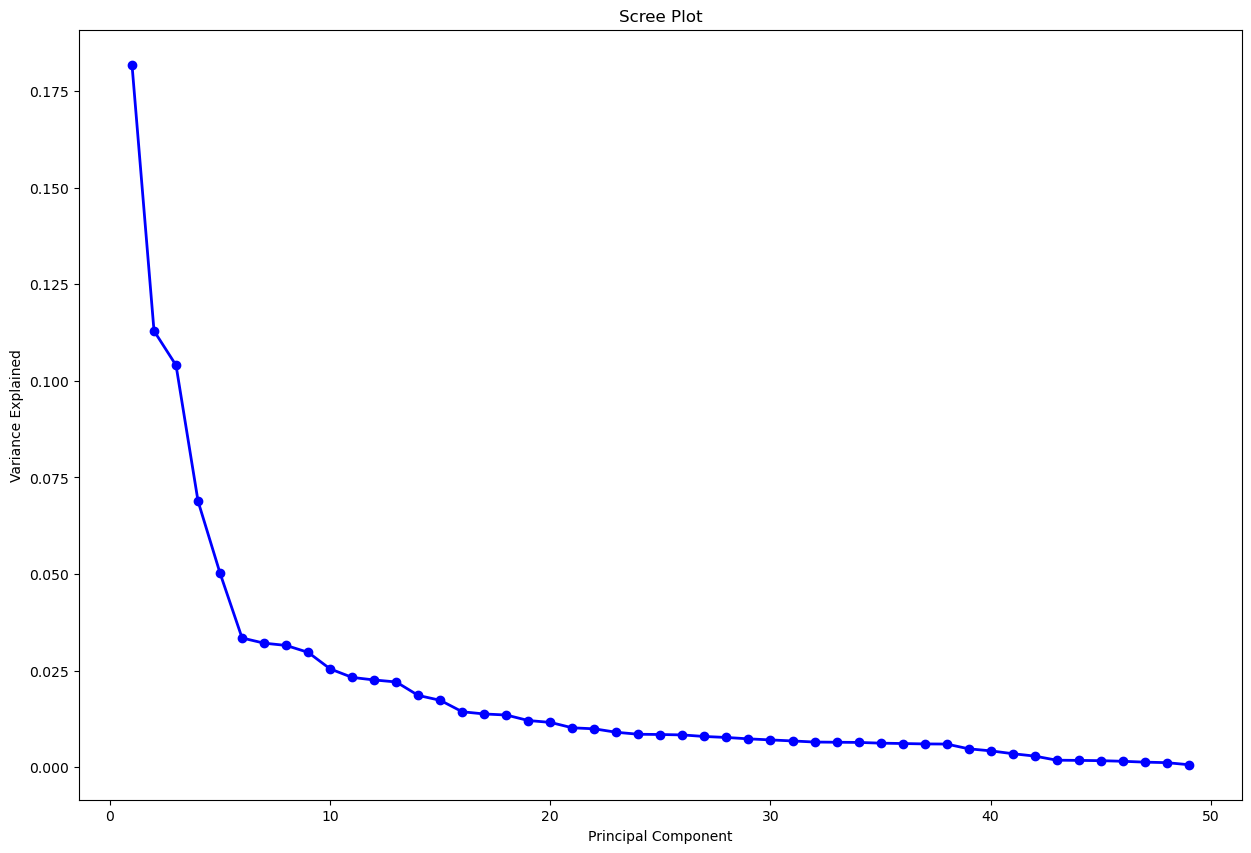

In [6]:
pca = PCA(random_state=24).fit(binary_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [7]:
pca = PCA(n_components=4, random_state=42)
transformed_data = pca.fit_transform(binary_matrix)

In [8]:
def kmeans_elbow_method(data, max_k=10, figsize=(15, 8)):
    ssd = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        
        # Fit the k-means clustering model to the data
        kmeans.fit(data)
        
        # Calculate the sum of squared distances
        ssd.append(kmeans.inertia_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Sum of squared distances', color='b')
    ax1.plot(range(2, max_k+1), ssd, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    plt.show()

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

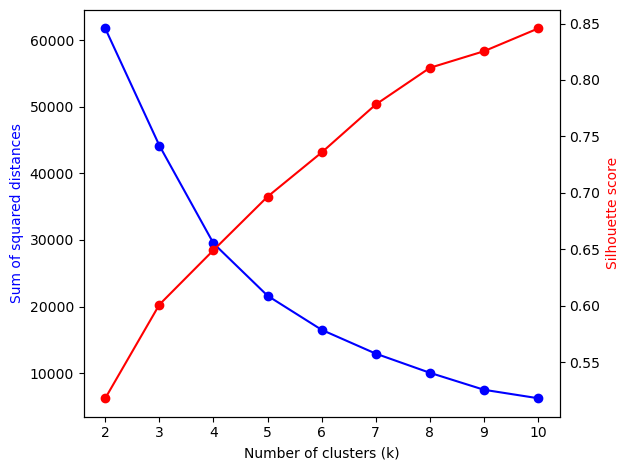

In [9]:
kmeans_elbow_method(transformed_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


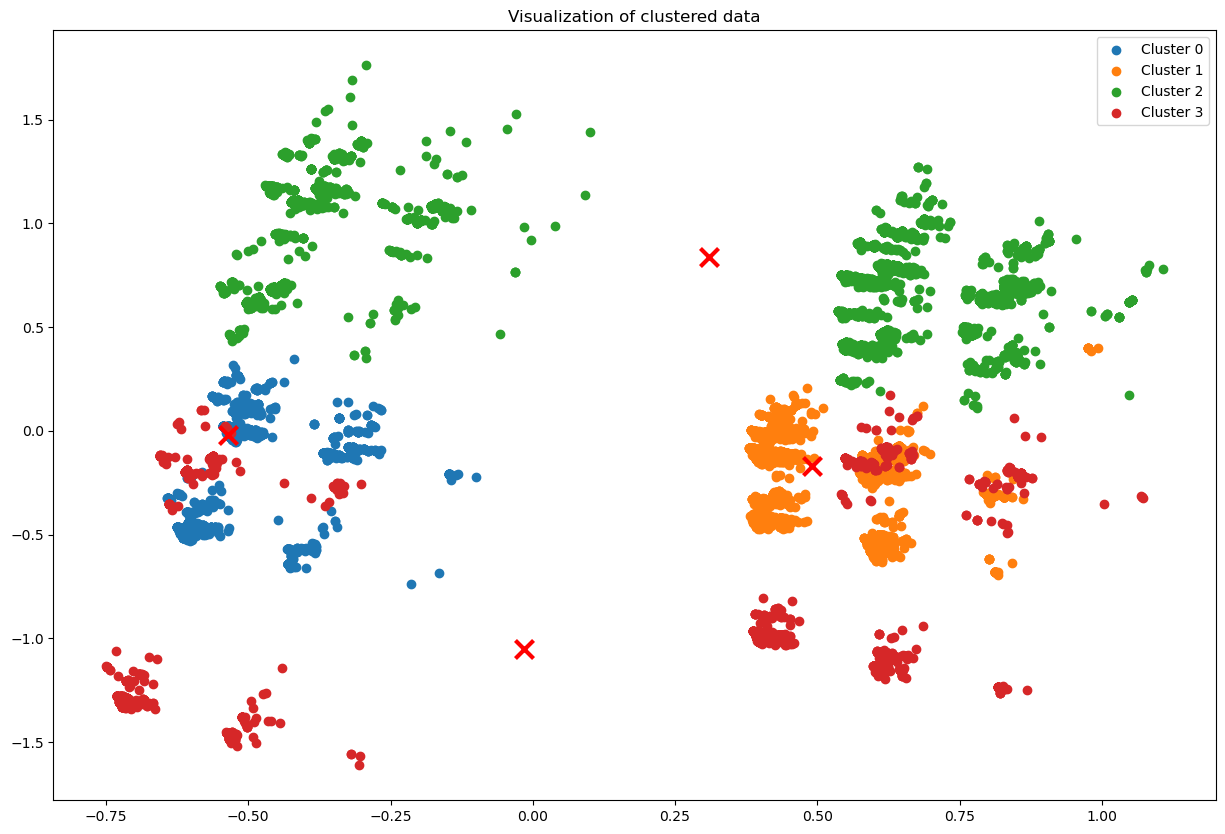

In [10]:
# Number of cluster for K-means to be 4 
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_data[cluster_labels == i, 0], transformed_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered data')
plt.show()

In [11]:
binary_matrix['kmeans_cluster'] = cluster_labels

In [12]:
# Interpreting the itemset frequencies in each cluster
cluster_itemset_frequencies = binary_matrix.groupby('kmeans_cluster').sum()
cluster_itemset_frequencies

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,1629,419,1066,637,158,49,195,677,111,181,...,0,0,0,0,0,0,2471,1823,408,0
1,11478,773,12393,1813,1205,245,640,523,1152,583,...,0,0,0,0,0,0,0,0,0,0
2,1459,218,1225,310,22,2345,3173,344,44,3035,...,2262,2159,2959,5939,2216,0,188,114,1127,0
3,707,90,423,55,83,46,74,112,122,93,...,52,49,90,177,78,5394,2268,2268,64,2268


In [13]:
binary_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)",kmeans_cluster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136448,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,2
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
import ast
binary_matrix['bakery_level'] = binary_matrix.apply(lambda row: max([len(col) for col, val in row.items() if val == 1 and col != 'kmeans_cluster' and col!='bakery_level'], default=0), axis=1)
binary_matrix


,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)",kmeans_cluster,bakery_level
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
136447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136448,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,2,2
136449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
cluster_bakery_level_counts = binary_matrix.groupby(['kmeans_cluster', 'bakery_level']).size()
cluster_bakery_level_counts

kmeans_cluster  bakery_level
0               1               53207
                2                6121
1               0                3407
                1               48738
                2                 632
2               1                 902
                2               18050
3               2                3126
                3                2268
dtype: int64

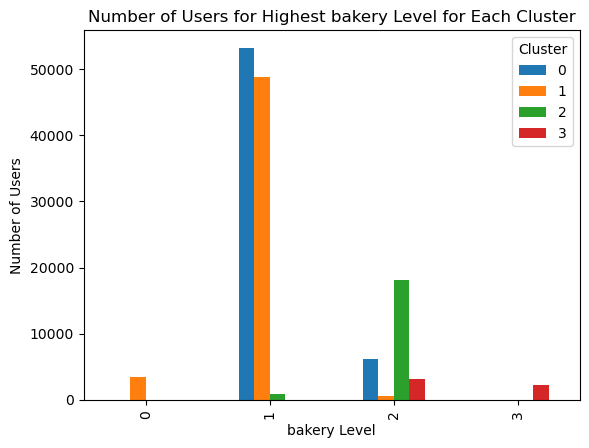

In [16]:
df_counts = cluster_bakery_level_counts.reset_index(name='counts')

df_pivot = df_counts.pivot(index='bakery_level', columns='kmeans_cluster', values='counts')

# Replace NaN values with 0
df_pivot.fillna(0, inplace=True)

# Create a bar plot
df_pivot.plot.bar()

# Add labels and title
plt.xlabel('bakery Level')
plt.ylabel('Number of Users')
plt.title('Number of Users for Highest bakery Level for Each Cluster')
plt.legend(title='Cluster')

# Show the plot
plt.show()

In [17]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.6492232429709243
Kmeans Davies-Bouldin Index: 0.7015165225312799
Kmeans Calinski-Harabasz Index: 107716.63872353976


In [18]:
transformed_data

array([[ 0.58414337, -0.52137409,  0.21179243,  0.71340956],
       [ 0.41050734, -0.41364502,  0.22729744, -0.06469055],
       [-0.54044848,  0.01609603, -0.18052718,  0.00216365],
       ...,
       [-0.32545388,  1.31584075,  0.72415079, -0.00480969],
       [-0.54044848,  0.01609603, -0.18052718,  0.00216365],
       [-0.54044848,  0.01609603, -0.18052718,  0.00216365]])

In [19]:
# Normalize just with frequency
def normalize_frequent_itemsets(binary_matrix, itemset_frequencies):
    
    normalized_matrix = binary_matrix.drop(columns=['kmeans_cluster', 'bakery_level']).copy()

    for column in normalized_matrix.columns:
        # Find the level of the itemset (number of items in the itemset)
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Normalize the column by the itemset frequency
        normalized_matrix[column] = normalized_matrix[column] / frequency

    return normalized_matrix

#  A TF-IDF kindda method 
def tf_idf_normalize(binary_matrix,itemset_frequencies):

    TF_IDF_matrix = binary_matrix.drop(columns=['kmeans_cluster', 'bakery_level']).copy()
    # For each column in the binary matrix
    for column in TF_IDF_matrix.columns:
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Calculate IDF
        IDF = np.log(len(TF_IDF_matrix)/frequency)
        TF_IDF_matrix[column] = TF_IDF_matrix[column] * IDF


    return TF_IDF_matrix

In [20]:
normalized_matrix = normalize_frequent_itemsets(binary_matrix, frequent_itemsets)
normalized_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,0.000065,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000065,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000066,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136447,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136448,0.000000,0.0,0.000000,0.0,0.0,0.000372,0.0,0.0,0.0,0.000257,...,0.0,0.0,0.0,0.000164,0.0,0.0,0.0,0.0,0.0,0.0
136449,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


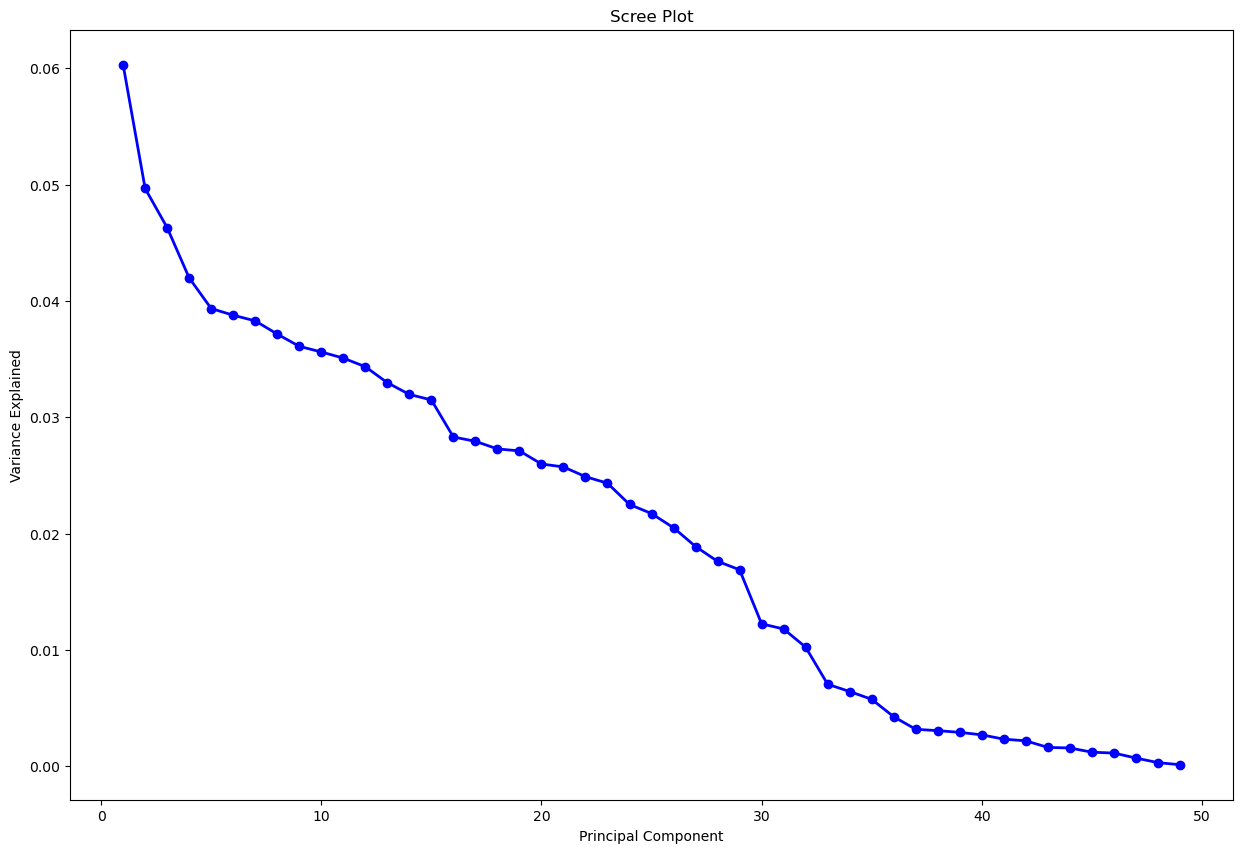

In [21]:
pca = PCA(random_state=24).fit(normalized_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [22]:
pca = PCA(n_components=5, random_state=42)
transformed_normalized_data = pca.fit_transform(normalized_matrix)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

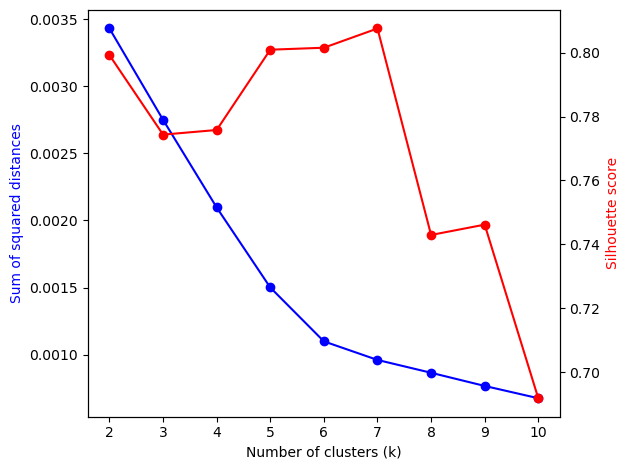

In [23]:
kmeans_elbow_method(transformed_normalized_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


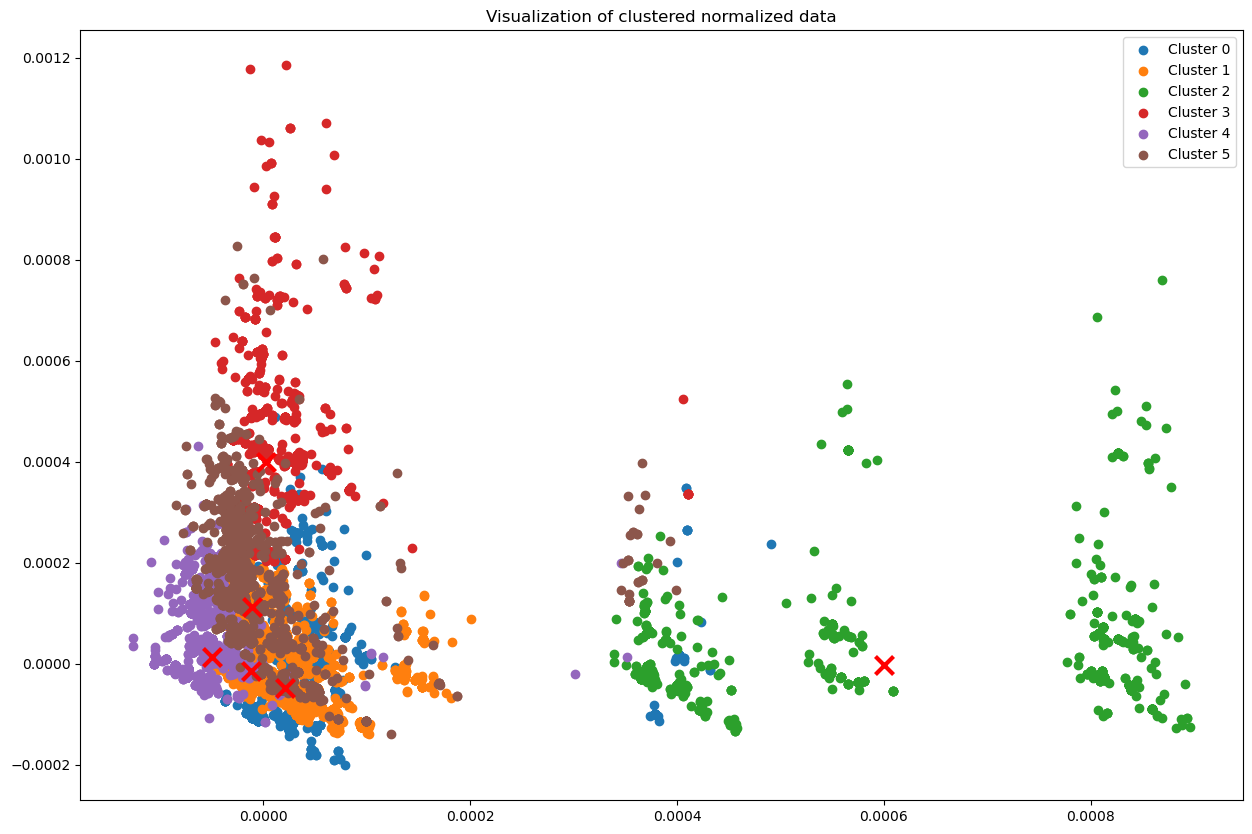

In [24]:
# Number of cluster for K-means to be 4 
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_normalized_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_normalized_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_normalized_data[cluster_labels == i, 0], transformed_normalized_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered normalized data')
plt.show()

In [25]:
Kmeans_Normalized_silhouette, Kmeans_Normalized_davies_bouldin, Kmeans_Normalized_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_normalized_data)

print(f'Kmeans Normalized Silhouette score: {Kmeans_Normalized_silhouette}')
print(f'Kmeans Normalized Davies-Bouldin Index: {Kmeans_Normalized_davies_bouldin}')
print(f'Kmeans Normalized Calinski-Harabasz Index: {Kmeans_Normalized_calinski_harabasz}')

Kmeans Normalized Silhouette score: 0.8015673513038212
Kmeans Normalized Davies-Bouldin Index: 0.658954654318808
Kmeans Normalized Calinski-Harabasz Index: 82574.53243793789


In [26]:
TF_IDF_matrix = tf_idf_normalize(binary_matrix, frequent_itemsets)
TF_IDF_matrix

,"(BAGUETTE,)","(BAGUETTE GRAINE,)","(BANETTE,)","(BANETTINE,)","(BOISSON 33CL,)","(BOULE 200G,)","(BOULE 400G,)","(BRIOCHE,)","(CAFE OU EAU,)","(CAMPAGNE,)",...,"(COMPLET, COUPE)","(COUPE, MOISSON)","(COUPE, SPECIAL BREAD)","(COUPE, TRADITIONAL BAGUETTE)","(COUPE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT)","(CROISSANT, TRADITIONAL BAGUETTE)","(PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)","(TRADITIONAL BAGUETTE, VIK BREAD)","(CROISSANT, PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)"
0,2.189879,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2.189879,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,2.200807,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136446,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136447,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
136448,0.000000,0.0,0.000000,0.0,0.0,3.928285,0.0,0.0,0.0,3.557042,...,0.0,0.0,0.0,3.105057,0.0,0.0,0.0,0.0,0.0,0.0
136449,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


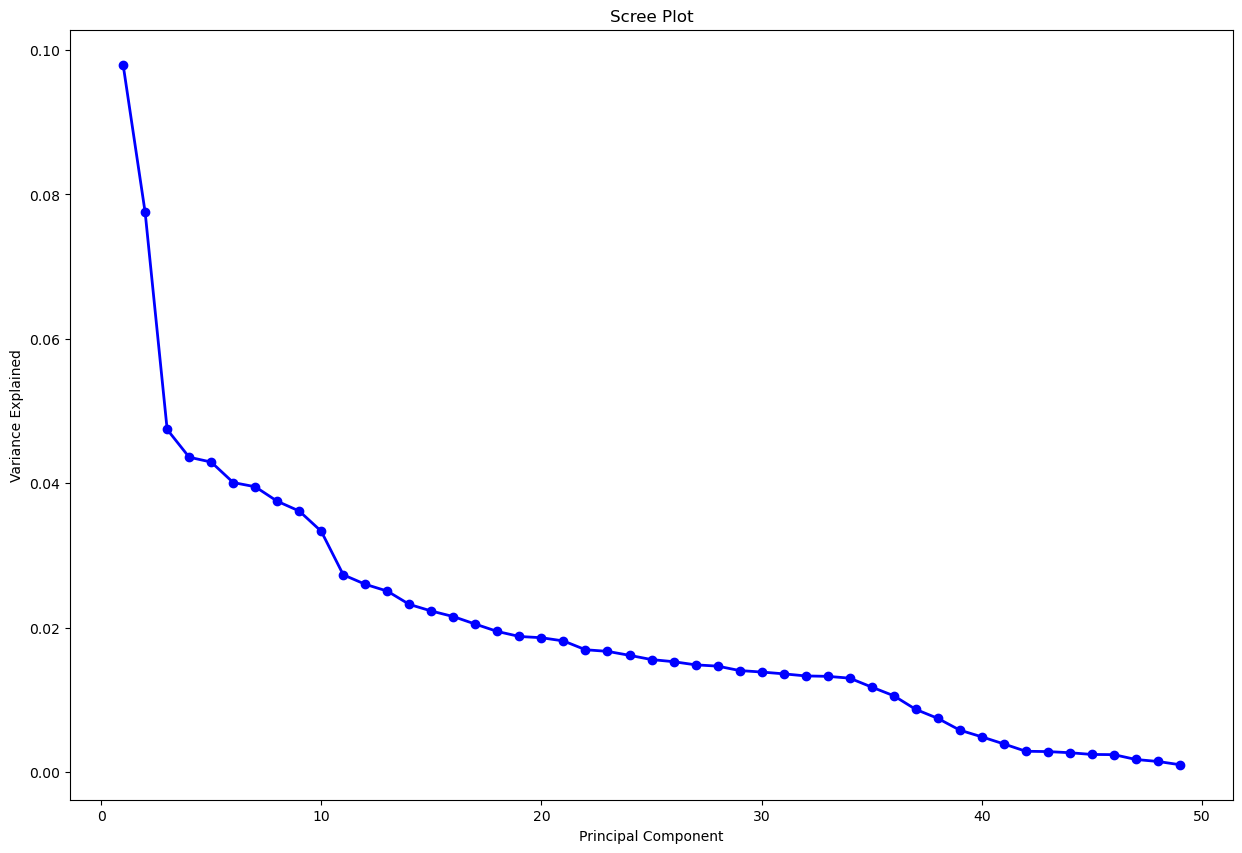

In [27]:
pca = PCA(random_state=24).fit(TF_IDF_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [28]:
pca = PCA(n_components=5,random_state=42)
transformed_TF_IDF_data = pca.fit_transform(TF_IDF_matrix)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

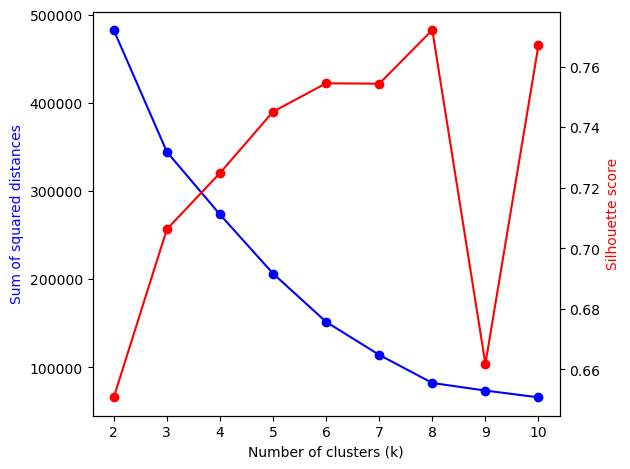

In [29]:
kmeans_elbow_method(transformed_TF_IDF_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


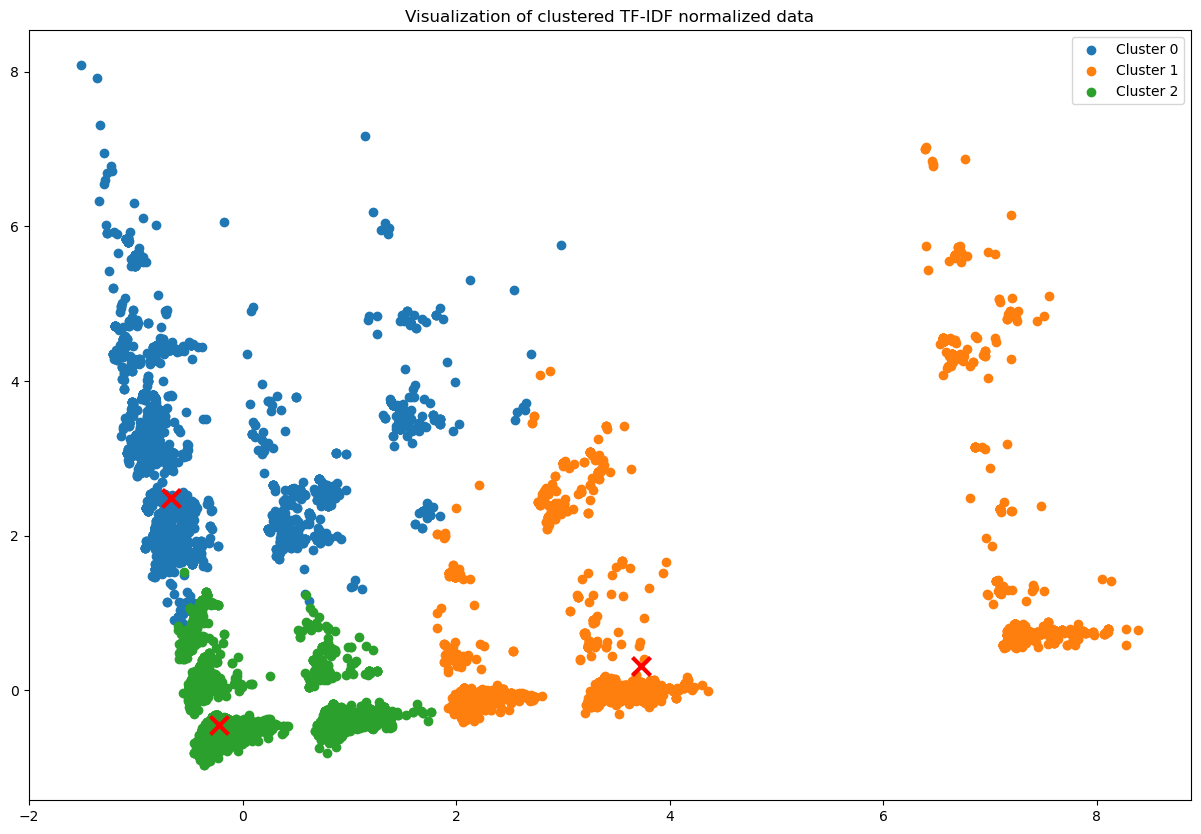

In [30]:
# Number of cluster for K-means to be 4 
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_TF_IDF_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_TF_IDF_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_TF_IDF_data[cluster_labels == i, 0], transformed_TF_IDF_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered TF-IDF normalized data')
plt.show()

In [31]:
Kmeans_TF_IDF_silhouette, Kmeans_TF_IDF_davies_bouldin, Kmeans_TF_IDF_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_TF_IDF_data)

print(f'Kmeans TFIDF Silhouette score: {Kmeans_TF_IDF_silhouette}')
print(f'Kmeans TFIDF Davies-Bouldin Index: {Kmeans_TF_IDF_davies_bouldin}')
print(f'Kmeans TFIDF Calinski-Harabasz Index: {Kmeans_TF_IDF_calinski_harabasz}')

Kmeans TFIDF Silhouette score: 0.7062872786520463
Kmeans TFIDF Davies-Bouldin Index: 1.152521538439806
Kmeans TFIDF Calinski-Harabasz Index: 56362.26089915244
